In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
import xgboost as xgb
from plotnine import ggplot, aes, geom_point, geom_line
import pyreadr

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# Data processing

In [3]:
# Read data
data = pyreadr.read_r('song_data.rds') 
data = data[None]

# Filter data for release year 2018
ml_data = data[data['release_year'] == '2018']
# print(ml_data)

# Group by tag and select top 1900 rows based on listen_times
ml_data = ml_data.groupby('tag').apply(lambda x: x.nlargest(1900, 'listen_times')).reset_index(drop=True)

# Split data into train and test sets
ml_train = ml_data.groupby('tag').apply(lambda x: x.sample(frac=0.8, random_state=210016)).reset_index(drop=True)
ml_test = pd.concat([ml_data, ml_train]).drop_duplicates(keep=False).reset_index(drop=True)

# Select relevant columns for training and testing
ml_train = ml_train.iloc[:, [1] + list(range(6, 17))]
ml_test = ml_test.iloc[:, [1] + list(range(6, 17))]

# Training

## Naive Bayes

In [4]:
# Train Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(ml_train.iloc[:, 1:], ml_train.iloc[:, 0])

# Predict on train set
p_train = nb_model.predict(ml_train.iloc[:, 1:])
print(p_train)
print(sum(p_train == ml_train.iloc[:, 0]) / len(p_train))

# Predict on test set
p_test = nb_model.predict(ml_test.iloc[:, 1:])
p_test_prob = nb_model.predict_proba(ml_test.iloc[:, 1:])
print(p_test)
print(sum(p_test == ml_test.iloc[:, 0]) / len(p_test))
print(roc_auc_score(ml_test.iloc[:, 0], p_test_prob, multi_class='ovr'))

['folk' 'folk' 'pop' ... 'folk' 'folk' 'pop']
0.46365131578947366
['folk' 'folk' 'folk' ... 'folk' 'folk' 'hiphop']
0.4598684210526316
0.7478693444136658


## K-Nearest Neighbors

In [5]:
df_knn_auc = pd.DataFrame(columns=['k', 'acc', 'auc'])
for k in range(1, 20):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(ml_train.iloc[:, 1:], ml_train.iloc[:, 0])
    knn_pred = knn_model.predict(ml_test.iloc[:, 1:])
    acc = sum(knn_pred == ml_test.iloc[:, 0]) / len(knn_pred)
    auc = roc_auc_score(ml_test.iloc[:, 0], knn_model.predict_proba(ml_test.iloc[:, 1:]), multi_class='ovr')
    df_knn_auc = pd.concat([df_knn_auc, pd.DataFrame.from_records([{'k': k, 'acc': acc, 'auc': auc}])])
    print(k)
df_knn_auc = df_knn_auc.sort_values(['acc','auc'], ascending=[False,False]).head(10)
print(df_knn_auc)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
    k       acc       auc
0  17  0.582237  0.805445
0  11  0.580921  0.797304
0  16  0.580263  0.804852
0  18  0.579605  0.805977
0  12  0.579605  0.797509
0  15  0.578289  0.803440
0  19  0.577632  0.805069
0  13  0.576316  0.799388
0  10  0.576316  0.793913
0  14  0.575658  0.800938


## Random Forest

In [6]:
df_rf_auc = pd.DataFrame(columns=['n', 'max', 'acc', 'auc'])
for n in range(80, 101):
    # for max_nodes in range(80, 101):
    for max_nodes in range(98, 101):
        rf_model = RandomForestClassifier(n_estimators=n, max_depth=max_nodes)
        rf_model.fit(ml_train.iloc[:, 1:], ml_train.iloc[:, 0])
        rf_pred = rf_model.predict(ml_test.iloc[:, 1:])
        acc = sum(rf_pred == ml_test.iloc[:, 0]) / len(rf_pred)
        auc = roc_auc_score(ml_test.iloc[:, 0], rf_model.predict_proba(ml_test.iloc[:, 1:]), multi_class='ovr')
        df_rf_auc = pd.concat([df_rf_auc, pd.DataFrame.from_records([{'n': n, 'max': max_nodes, 'acc': acc, 'auc': auc}])])
        print('depth :',max_nodes)
    print('n :',n)
df_rf_auc = df_rf_auc.sort_values(['acc','auc'], ascending=[False,False]).head(10)
print(df_rf_auc)

depth : 98
depth : 99
depth : 100
n : 80
depth : 98
depth : 99
depth : 100
n : 81
depth : 98
depth : 99
depth : 100
n : 82
depth : 98
depth : 99
depth : 100
n : 83
depth : 98
depth : 99
depth : 100
n : 84
depth : 98
depth : 99
depth : 100
n : 85
depth : 98
depth : 99
depth : 100
n : 86
depth : 98
depth : 99
depth : 100
n : 87
depth : 98
depth : 99
depth : 100
n : 88
depth : 98
depth : 99
depth : 100
n : 89
depth : 98
depth : 99
depth : 100
n : 90
depth : 98
depth : 99
depth : 100
n : 91
depth : 98
depth : 99
depth : 100
n : 92
depth : 98
depth : 99
depth : 100
n : 93
depth : 98
depth : 99
depth : 100
n : 94
depth : 98
depth : 99
depth : 100
n : 95
depth : 98
depth : 99
depth : 100
n : 96
depth : 98
depth : 99
depth : 100
n : 97
depth : 98
depth : 99
depth : 100
n : 98
depth : 98
depth : 99
depth : 100
n : 99
depth : 98
depth : 99
depth : 100
n : 100
     n  max       acc       auc
0  100   98  0.619079  0.831181
0   80   99  0.617763  0.826546
0   94  100  0.616447  0.827918
0   93   9

## XGBoost

In [7]:
ml_train_num = ml_train.copy()
ml_train_num['tag'] = ml_train_num['tag'].replace({'pop': 0, 'hiphop': 1, 'rock': 2, 'folk': 3})
ml_test_num = ml_test.copy()
ml_test_num['tag'] = ml_test_num['tag'].replace({'pop': 0, 'hiphop': 1, 'rock': 2, 'folk': 3})
train_matrix = xgb.DMatrix(data=ml_train_num.iloc[:, 1:], label=ml_train_num.iloc[:, 0])
test_matrix = xgb.DMatrix(data=ml_test_num.iloc[:, 1:], label=ml_test_num.iloc[:, 0])
best_param = {}
best_seednumber = 1234
best_logloss = float('inf')
best_logloss_index = 0
for n in range(10):
    param = {
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 4,
        'max_depth': np.random.choice(range(2, 6)),
        'eta': np.random.uniform(0.01, 0.1),
        'gamma': np.random.uniform(0.0, 0.2),
        'subsample': np.random.uniform(0.6, 0.9),
        'colsample_bytree': np.random.uniform(0.5, 0.8),
        'min_child_weight': np.random.choice(range(1, 41)),
        'max_delta_step': np.random.choice(range(1, 11))
    }
    seed_number = np.random.randint(10000)
    cv_result = xgb.cv(param, train_matrix, num_boost_round=500, nfold=5, early_stopping_rounds=8, seed=seed_number)
    min_logloss = cv_result['test-mlogloss-mean'].min()
    min_logloss_index = cv_result['test-mlogloss-mean'].idxmin()
    if min_logloss < best_logloss:
        best_logloss = min_logloss
        best_logloss_index = min_logloss_index
        best_seednumber = seed_number
        best_param = param
    print(n)
nround = best_logloss_index
bst_model = xgb.train(best_param, train_matrix, num_boost_round=nround)

0
1
2
3
4
5
6
7
8
9


In [8]:
# Predict on test set using XGBoost model
test_pred = bst_model.predict(test_matrix)
x_test_prediction = pd.DataFrame(test_pred).apply(lambda x: x.idxmax(), axis=1)
y_test_prediction = ml_test.iloc[:, 0].map({'pop': 0, 'hiphop': 1, 'rock': 2, 'folk': 3})
print(confusion_matrix(x_test_prediction, y_test_prediction))
y_true = ml_test['tag'].to_numpy()
y_true = np.unique(y_true, return_inverse=True)[1]
print(roc_auc_score(y_true, test_pred, multi_class='ovr'))

[[219  39  56  84]
 [ 44 296  55  26]
 [ 39  27 200  53]
 [ 78  18  69 217]]
0.5831850184672207


# Prediction

## Preprocess data for prediction

In [9]:
# data_predict = data[data['release_year'].isin([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
data_predict = data[data['release_year'].isin(['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'])]
data_predict['release_year'] = pd.to_datetime(data_predict['release_date']).dt.year
data_predict['tag_bin'] = data_predict['tag'].map({'hiphop': 'hiphop', 'pop': 'nonhiphop'})
data_predict['treatment_date'] = (data_predict['release_date'] < pd.to_datetime('2017-06-24')).astype(int)
data_predict['treatment_year'] = (data_predict['release_year'] < 2017).astype(int)
print(data_predict)
x_data_predict = data_predict.iloc[:, 6:17]

            song_id   tag release_date  release_month  release_year  \
1       xNgVaKafcd0   pop   2017-09-08    2017.666667          2017   
2       mSOdaq656ff  rock   2015-11-11    2015.833333          2015   
3      bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016   
4       xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015   
5      bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016   
...             ...   ...          ...            ...           ...   
94811   mSFWvm87f0a   pop   2012-07-12    2012.500000          2012   
94812   xNPVxjbf14e   pop   2015-04-08    2015.250000          2015   
94813   8IAUlNe26fb   pop   2015-04-08    2015.250000          2015   
94814  bCniNa4469b4   pop   2016-04-08    2016.250000          2016   
94815   xNPVxla3162   pop   2015-04-08    2015.250000          2015   

       listen_times  chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1             952.0          0.313235   0.226911                0.32528

/tmp/ipykernel_5249/1356963040.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5249/1356963040.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5249/1356963040.py:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/tmp/ipykernel_5249/1356963040.py:5: SettingWithCopyWarning: 
A valu

## Naive Bayes

In [10]:
data_predict['gnb_pred'] = nb_model.predict(x_data_predict)
data_predict['gnb_pred_acc'] = (data_predict['gnb_pred'] == data_predict['tag']).astype(int)
data_predict['gnb_pred_bin'] = data_predict['gnb_pred'].map({'hiphop': 'hiphop', 'pop': 'nonhiphop'})
data_predict['gnb_pred_bin_acc'] = (data_predict['tag_bin'] == data_predict['gnb_pred_bin']).astype(int)

/tmp/ipykernel_5249/599511924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5249/599511924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5249/599511924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5249/59951192

## K-Nearest Neighbors

In [11]:
data_predict['knn_pred'] = knn_model.predict(x_data_predict)
data_predict['knn_pred_acc'] = (data_predict['knn_pred'] == data_predict['tag']).astype(int)
data_predict['knn_pred_bin'] = data_predict['knn_pred'].map({'hiphop': 'hiphop', 'pop': 'nonhiphop'})
data_predict['knn_pred_bin_acc'] = (data_predict['tag_bin'] == data_predict['knn_pred_bin']).astype(int)

/tmp/ipykernel_5249/1251774408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5249/1251774408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5249/1251774408.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5249/12517

## Random Forest

In [12]:
data_predict['rf_pred'] = rf_model.predict(x_data_predict)
data_predict['rf_pred_acc'] = (data_predict['rf_pred'] == data_predict['tag']).astype(int)
data_predict['rf_pred_bin'] = data_predict['rf_pred'].map({'hiphop': 'hiphop', 'pop': 'nonhiphop'})
data_predict['rf_pred_bin_acc'] = (data_predict['tag_bin'] == data_predict['rf_pred_bin']).astype(int)

/tmp/ipykernel_5249/2113506275.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5249/2113506275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5249/2113506275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5249/21135

## XGBoost

In [13]:
data_predict_xgb = bst_model.predict(xgb.DMatrix(x_data_predict))
data_predict['xgb_pred'] = pd.DataFrame(data_predict_xgb).apply(lambda x: x.idxmax(), axis=1)
data_predict['xgb_pred_acc'] = (data_predict['xgb_pred'] == data_predict['tag']).astype(int)
data_predict['xgb_pred_bin'] = data_predict['xgb_pred'].map({'hiphop': 'hiphop', 'pop': 'nonhiphop'})
data_predict['xgb_pred_bin_acc'] = (data_predict['tag_bin'] == data_predict['xgb_pred_bin']).astype(int)

/tmp/ipykernel_5249/2954023184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5249/2954023184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5249/2954023184.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_5249/29540

# Metrics

## Naive Bayes

,release_year,treatment_year,gnb_pred_acc,gnb_pred_bin_acc,gnb_recall,gnb_precision
0,2009,1,0.249642,0.157368,0.703704,0.069343
1,2010,1,0.265951,0.202148,0.781022,0.154624
2,2011,1,0.262842,0.159563,0.787611,0.110973
3,2012,1,0.333625,0.211909,0.708487,0.188420
4,2013,1,0.285282,0.171035,0.684713,0.167969
5,2014,1,0.325967,0.188988,0.718905,0.256547
6,2015,1,0.333874,0.172612,0.726580,0.258027
7,2016,1,0.284222,0.167537,0.667845,0.207161
8,2017,0,0.349844,0.225467,0.753488,0.366667
9,2018,0,0.349840,0.249286,0.750275,0.423011


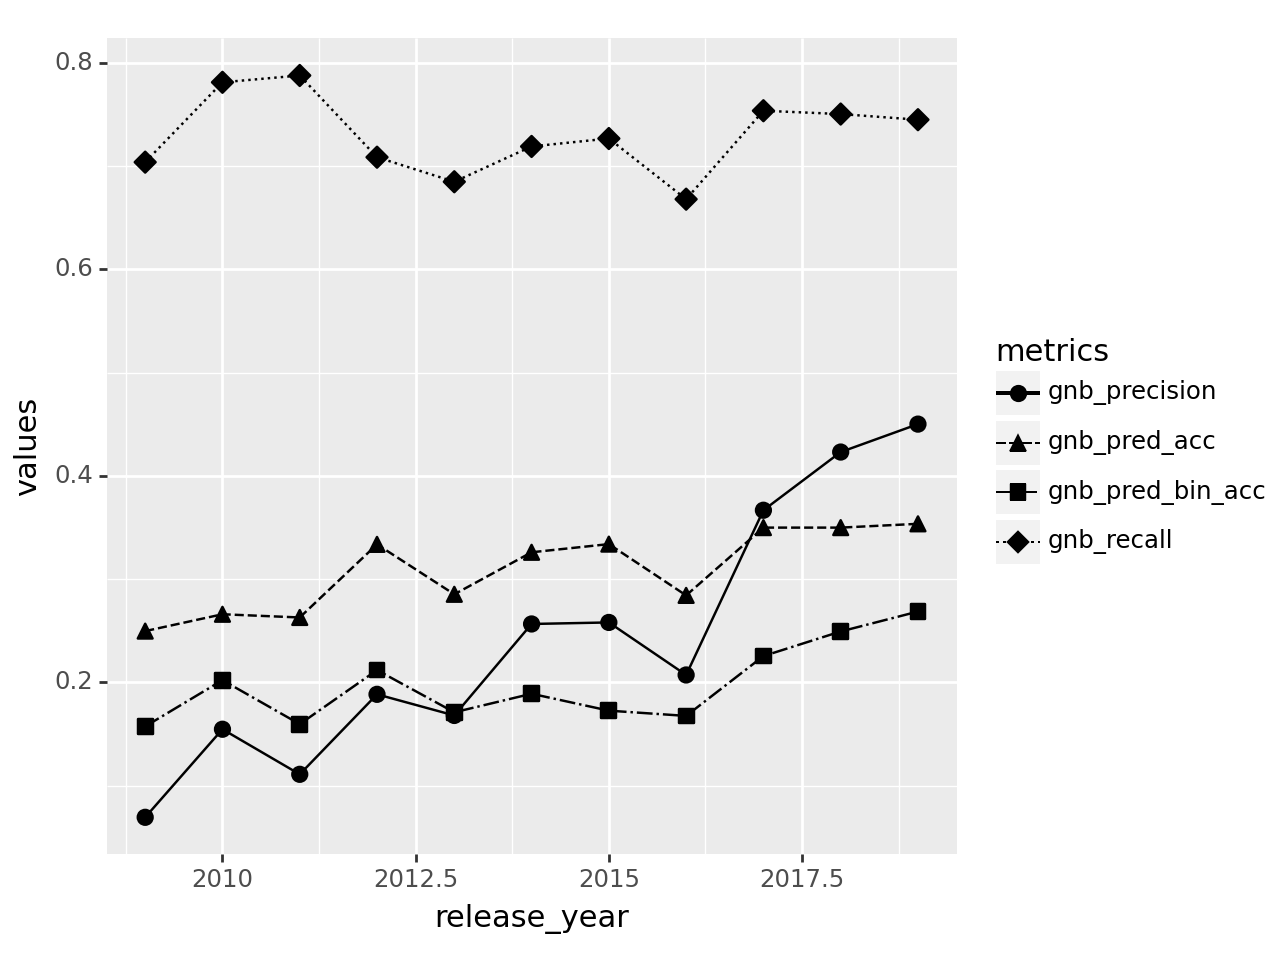

In [19]:
gnb_mean_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index()
gnb_mean_bin_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['gnb_pred_bin_acc'].mean().reset_index()
gnb_recall_tbyyear = data_predict[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index().rename(columns={'gnb_pred_acc':'gnb_recall'})
gnb_precision_tbyyear = data_predict[data_predict['gnb_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index().rename(columns={'gnb_pred_acc':'gnb_precision'})
gnb_metrics = pd.concat([gnb_mean_acc_tbyyear, gnb_mean_bin_acc_tbyyear['gnb_pred_bin_acc'], gnb_recall_tbyyear['gnb_recall'], gnb_precision_tbyyear['gnb_precision']], axis=1)
display(gnb_metrics)
gnb_metrics = gnb_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
gnb_metrics_plot = ggplot(gnb_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + geom_line(aes(linetype='metrics'))
print(gnb_metrics_plot)

gnb_metrics.to_pickle('pickles/gnb_metrics_2018.pkl')

## K-Nearest Neighbors

,release_year,treatment_year,knn_pred_acc,knn_pred_bin_acc,knn_recall,knn_precision
0,2009,1,0.469242,0.360515,0.629630,0.185792
1,2010,1,0.514845,0.415666,0.664234,0.317073
2,2011,1,0.467760,0.333880,0.654867,0.239482
3,2012,1,0.519702,0.362522,0.590406,0.366133
4,2013,1,0.460685,0.321909,0.627389,0.333898
5,2014,1,0.482949,0.299295,0.608209,0.459586
6,2015,1,0.465507,0.274469,0.617647,0.441933
7,2016,1,0.435129,0.291231,0.587750,0.347735
8,2017,0,0.489252,0.348053,0.701480,0.574446
9,2018,0,0.518730,0.397670,0.743399,0.628166


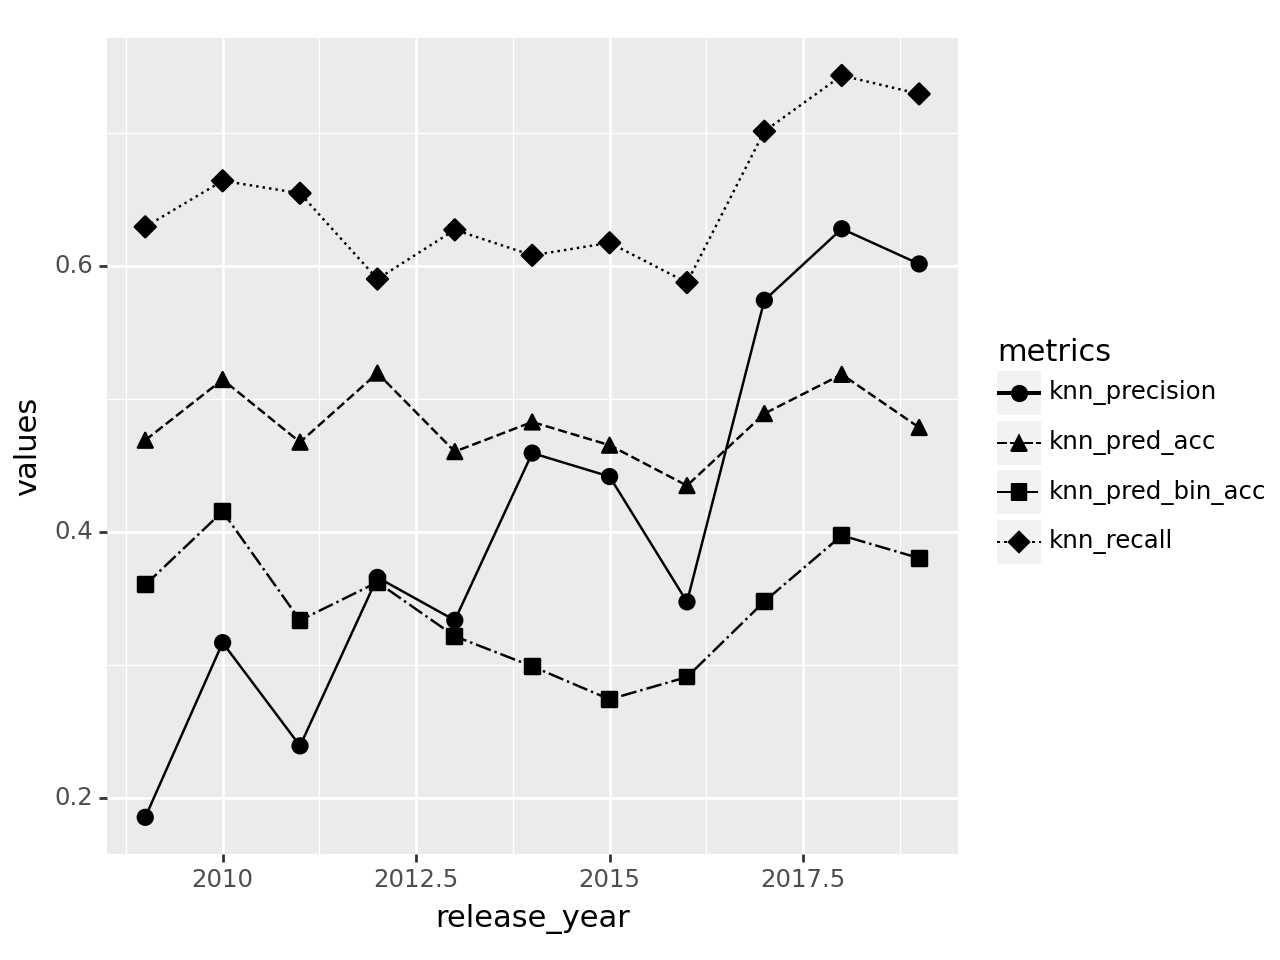

In [20]:
knn_mean_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index()
knn_mean_bin_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['knn_pred_bin_acc'].mean().reset_index()
knn_recall_tbyyear = data_predict[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index().rename(columns={'knn_pred_acc':'knn_recall'})
knn_precision_tbyyear = data_predict[data_predict['knn_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index().rename(columns={'knn_pred_acc':'knn_precision'})
knn_metrics = pd.concat([knn_mean_acc_tbyyear, knn_mean_bin_acc_tbyyear['knn_pred_bin_acc'], knn_recall_tbyyear['knn_recall'], knn_precision_tbyyear['knn_precision']], axis=1)
display(knn_metrics)
knn_metrics = knn_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
knn_metrics_plot = ggplot(knn_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + geom_line(aes(linetype='metrics'))
print(knn_metrics_plot)

knn_metrics.to_pickle('pickles/knn_metrics_2018.pkl')

## Random Forest

,release_year,treatment_year,rf_pred_acc,rf_pred_bin_acc,rf_recall,rf_precision
0,2009,1,0.483548,0.366953,0.722222,0.195000
1,2010,1,0.539482,0.416930,0.737226,0.337793
2,2011,1,0.461749,0.309836,0.654867,0.240260
3,2012,1,0.539842,0.365587,0.619926,0.390698
4,2013,1,0.462702,0.313172,0.652866,0.343384
5,2014,1,0.489046,0.291865,0.661692,0.463819
6,2015,1,0.474351,0.267983,0.648148,0.442379
7,2016,1,0.443101,0.289170,0.634865,0.365176
8,2017,0,0.494938,0.343692,0.736152,0.571569
9,2018,0,0.655578,0.454064,0.876238,0.714831


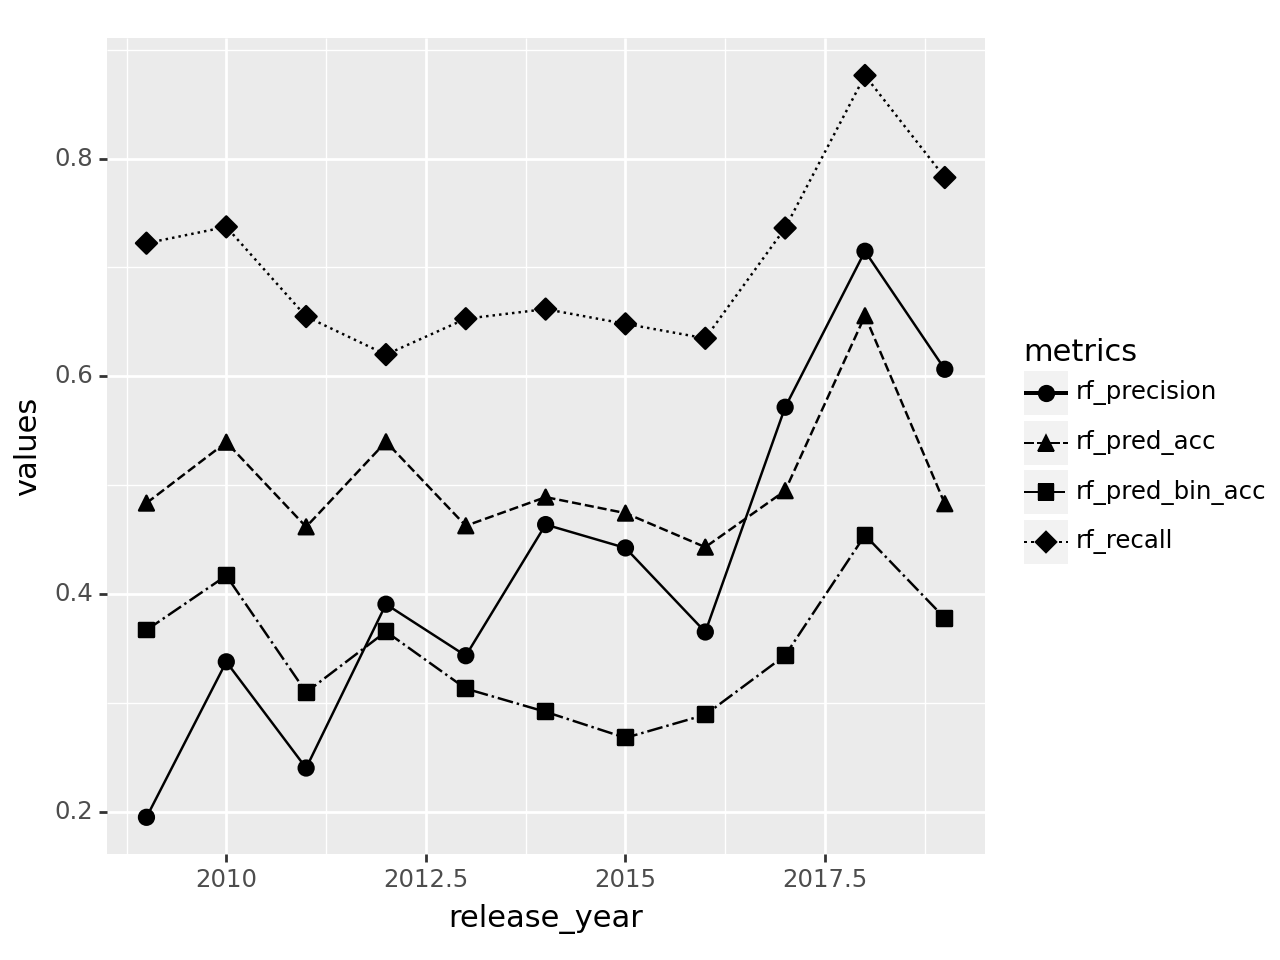

In [21]:
rf_mean_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index()
rf_mean_bin_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['rf_pred_bin_acc'].mean().reset_index()
rf_recall_tbyyear = data_predict[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index().rename(columns={'rf_pred_acc':'rf_recall'})
rf_precision_tbyyear = data_predict[data_predict['rf_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index().rename(columns={'rf_pred_acc':'rf_precision'})
rf_metrics = pd.concat([rf_mean_acc_tbyyear, rf_mean_bin_acc_tbyyear['rf_pred_bin_acc'], rf_recall_tbyyear['rf_recall'], rf_precision_tbyyear['rf_precision']], axis=1)
display(rf_metrics)
rf_metrics = rf_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
rf_metrics_plot = ggplot(rf_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + geom_line(aes(linetype='metrics'))
print(rf_metrics_plot)

rf_metrics.to_pickle('pickles/rf_metrics_2018.pkl')

## XGBoost

,release_year,treatment_year,xgb_pred_acc,xgb_pred_bin_acc,xgb_recall,xgb_precision
0,2009,1,0.0,0.0,0.0,NaN
1,2010,1,0.0,0.0,0.0,NaN
2,2011,1,0.0,0.0,0.0,NaN
3,2012,1,0.0,0.0,0.0,NaN
4,2013,1,0.0,0.0,0.0,NaN
5,2014,1,0.0,0.0,0.0,NaN
6,2015,1,0.0,0.0,0.0,NaN
7,2016,1,0.0,0.0,0.0,NaN
8,2017,0,0.0,0.0,0.0,NaN
9,2018,0,0.0,0.0,0.0,NaN


/home/priscilla/Programmes/anaconda3/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 11 rows containing missing values.
/home/priscilla/Programmes/anaconda3/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 11 rows containing missing values.


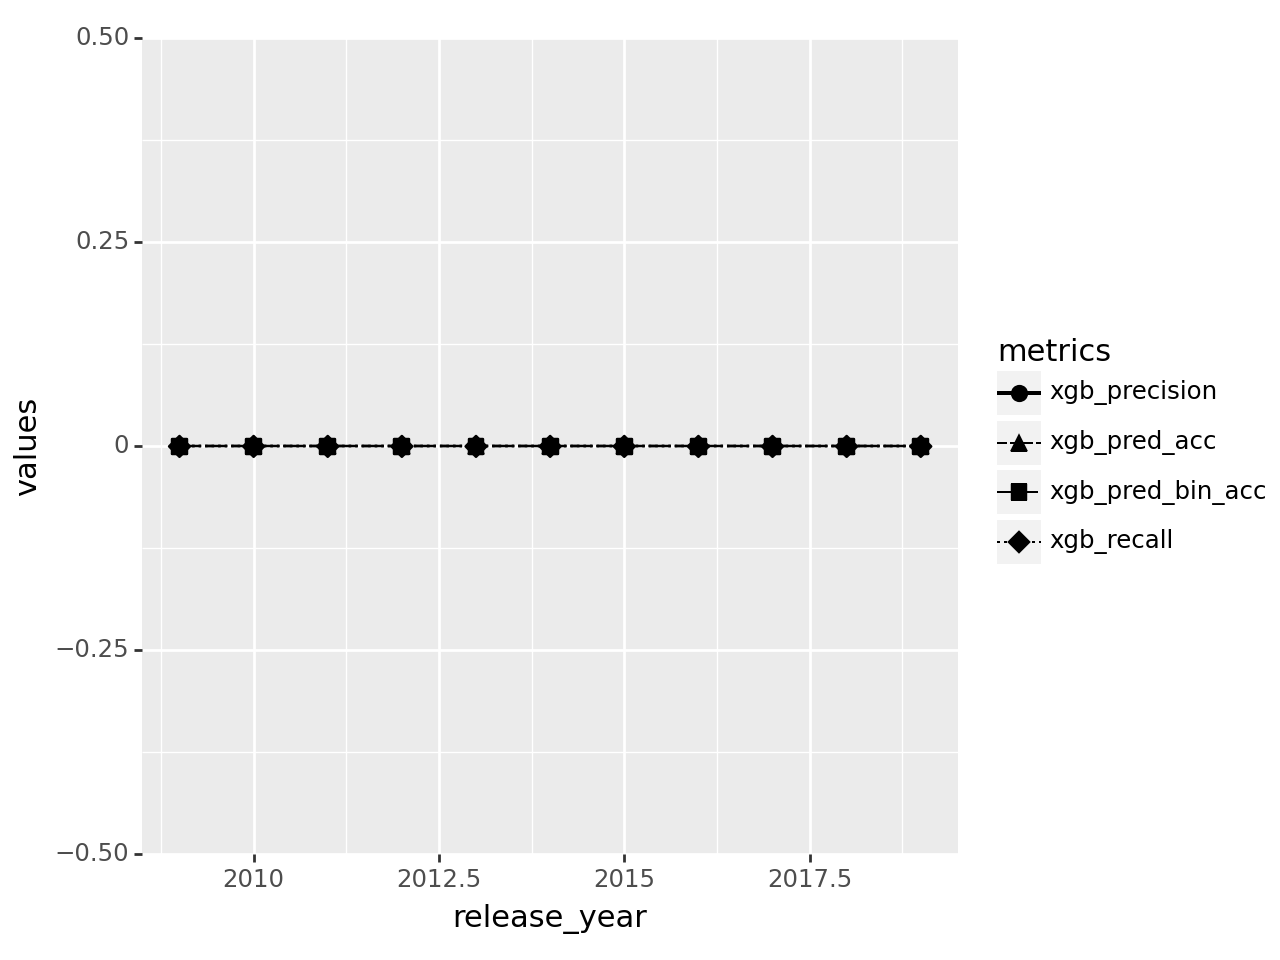

In [22]:
xgb_mean_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index()
xgb_mean_bin_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['xgb_pred_bin_acc'].mean().reset_index()
xgb_recall_tbyyear = data_predict[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index().rename(columns={'xgb_pred_acc':'xgb_recall'})
xgb_precision_tbyyear = data_predict[data_predict['xgb_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index().rename(columns={'xgb_pred_acc':'xgb_precision'})
xgb_metrics = pd.concat([xgb_mean_acc_tbyyear, xgb_mean_bin_acc_tbyyear['xgb_pred_bin_acc'], xgb_recall_tbyyear['xgb_recall'], xgb_precision_tbyyear['xgb_precision']], axis=1)
display(xgb_metrics)
xgb_metrics = xgb_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')

xgb_metrics_plot = ggplot(xgb_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + geom_line(aes(linetype='metrics'))
print(xgb_metrics_plot)

xgb_metrics.to_pickle('pickles/xgb_metrics_2018.pkl')

## Average

,release_year,treatment_year,metrics,values
0,2009,1,classifiers_pred_acc,0.300608
1,2010,1,classifiers_pred_acc,0.330069
2,2011,1,classifiers_pred_acc,0.298087
3,2012,1,classifiers_pred_acc,0.348292
4,2013,1,classifiers_pred_acc,0.302167
5,2014,1,classifiers_pred_acc,0.324490
6,2015,1,classifiers_pred_acc,0.318433
7,2016,1,classifiers_pred_acc,0.290613
8,2017,0,classifiers_pred_acc,0.333509
9,2018,0,classifiers_pred_acc,0.381037


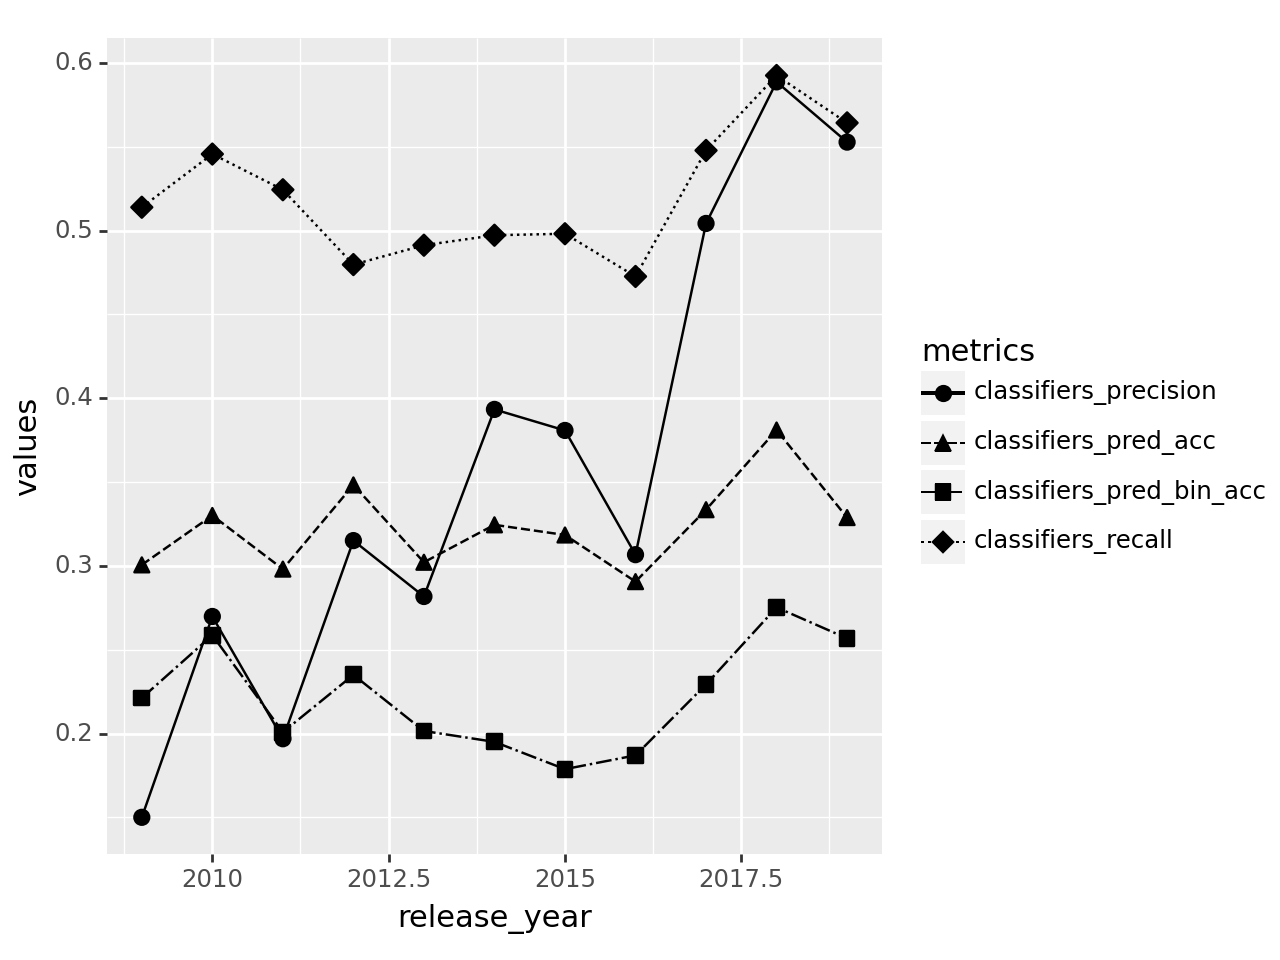

In [23]:
average = pd.concat([gnb_metrics['values'], knn_metrics['values'], rf_metrics['values'], xgb_metrics['values']], names = ['values', 'values_1', 'values_2', 'values_3'], axis=1)
average = average.mean(axis=1)
average = pd.concat([gnb_metrics['release_year'], gnb_metrics['treatment_year'], gnb_metrics['metrics'], average],axis=1)
average['metrics'] = average['metrics'].str.replace('gnb_', 'classifiers_')
average = average.rename(columns={0: "values"})
average.to_pickle('pickles/classifiers_metrics_2018.pkl')
display(average)

average_plot = ggplot(average, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + geom_line(aes(linetype='metrics'))
print(average_plot)